## Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import pathlib
import PIL

# Data Manipulation
import numpy as np
import pandas as pd

# Deep Learning
import tensorflow as tf
import tensorflow_datasets as tfds

# TensorFlow
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Sklearn
from sklearn import set_config
set_config(display="diagram")

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Remove TF info messages like "Plugin optimizer for device_type GPU is enabled"
# Also removes warnings, but not errors. Set to 1 for warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Data Pipelines with TensorFlow

🎯 **Objectives**
- How to make pipelines with Deep Learning
- How to load heavy data batch per batch

## **Part I: How to make pipelines with Deep Learning**

### Load Data (the Petfinder dataset)

👉 Let's load the **PetFinder** dataset. 
* Each row describes a pet
* Each column describes an attribute of a pet


🐶 You will use this information to ***predict whether a pet will be adopted or not***. 

| Column | Description| Feature Type | Data Type
|------------|--------------------|----------------------|-----------------
|Type | Type of animal (Dog, Cat) | Categorical | string
|Age |  Age of the pet | Numerical | integer
|Breed1 | Primary breed of the pet | Categorical | string
|Color1 | Color 1 of pet | Categorical | string
|Color2 | Color 2 of pet | Categorical | string
|MaturitySize | Size at maturity | Categorical | string
|FurLength | Fur length | Categorical | string
|Vaccinated | Pet has been vaccinated | Categorical | string
|Sterilized | Pet has been sterilized | Categorical | string
|Health | Health Condition | Categorical | string
|Fee | Adoption Fee | Numerical | integer
|Description | Profile write-up for this pet | Text | string
|PhotoAmt | Total uploaded photos for this pet | Numerical | integer
|AdoptionSpeed | Speed of adoption | Classification | integer
</details>

In [ ]:
pets = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/petfinder.csv")
pets

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,1
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,1
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,0


In [ ]:
pets.target.value_counts()

1    8457
0    3080
Name: target, dtype: int64

In [ ]:
round(pets.target.value_counts(normalize = True), 2)

1    0.73
0    0.27
Name: target, dtype: float64

In [ ]:
# Train-Test Split
train, test = train_test_split(pets, test_size=0.2)

# Train-Val Split
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


In [ ]:
# Separating features and target in the Train, Val and Test Set

X_train = train.drop(columns='target')
y_train = train['target']

X_val = val.drop(columns='target')
y_val = val['target']

X_test = test.drop(columns='target')
y_test = test['target']

☝️ Our dataset has both ***numerical*** and ***categorical values***. 

As for any Machine Learning / Deep Learning model, we need to preprocess them before training the model.

👨🏻‍🏫 You have three options:

* **(A)** Use Scikit-Learn to preprocess the dataset before feeding a Neural Network (no Pipeline)  
* **(B)** Wrap your Neural Network into a Scikit-Learn estimator and use a Scikit-Learn Pipeline
* **(C)** Use full Tensorflow pipelines  

### (A) 0️⃣ No pipeline

1. Preprocess data with Scikit-Learn 
2. Feed your Neural Network with the preprocessed data

#### (A.1) Preprocessing


❓ Create `X_train_preproc`, `X_val_preproc`, `X_test_preproc` ❓

* Scaling numerical features
* Encoding categorical features 

In [ ]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=["object"]))
)

preproc

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x2a63ae7d0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x2a63af730>)])

In [ ]:
preproc.fit_transform(X_train).shape

(7383, 184)

In [ ]:
X_train_preproc = preproc.fit_transform(X_train)
X_val_preproc = preproc.transform(X_val)
X_test_preproc = preproc.transform(X_test)

#### (A.2) Neural Network

❓ **Questions** ❓
* Design (Architecture + Compile) a Neural Network
* Fit it on the training set
* Evaluate its performance on the test set 

In [ ]:
model = Sequential()

# 1. Architecture
model.add(layers.Dense(32, activation='relu', input_shape=(X_train_preproc.shape[-1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# 2. Compiling
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                5920      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                495       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 6,431
Trainable params: 6,431
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 3. Training
es = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    verbose = 0,
    restore_best_weights = True
)

history = model.fit(
    X_train_preproc,
    y_train,
    validation_data = (X_val_preproc, y_val),
    batch_size = 64,
    epochs = 500,
    callbacks = [es],
    verbose = 0
)

In [ ]:
res = model.evaluate(X_test_preproc, y_test)
print(f"accuracy = {res[1]:.3f}")

73/73 [==============================] - 0s 5ms/step - loss: 0.4813 - accuracy: 0.7721
accuracy = 0.772


### (B) 👻 Wrapping a Neural Net into a Sklearn estimator 

👉 _Pipeline_ and _ColumnTransformer_ are designed for Machine Learning Models.

👻 So, how about disguising a Neural Network into a Scikit-Learn estimator to use the aforementioned tools? It is possible! We can treat a Tensorflow.Keras model as a Scikit-Learn estimator using 📚 [**Keras Wrappers**](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn) 📚

🔥 Now, we can **_CrossValidate_, _GridSearchCV_, _RandomizedSearchCV_ a Deep Learning model which is wrapped**. 🔥

#### (B.1) Introduction to Keras Wrappers

❓ Run the cells below and try understand the syntax ❓

In [ ]:
def create_model():

    ###########################
    #             1. Define architecture              #
    ###########################

    # Notice that we don't specify the input shape yet
    # as we don't know the shape post-preprocessing!
    # One consequence is that here, you cannot yet print
    # the model's summary. It will be known after fitting it
    # to X_train_preprocessed, y_train

    model = Sequential()
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(15, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    ###########################
    #                 2. Compile model                 #
    ###########################

    model.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )

    return model

In [ ]:
# It is "Halloween" time
# Disguise your Deep Learning Model into a Scikit Learn model

disguised_deep_model = KerasClassifier(
    build_fn = create_model,
    epochs = 10,
    batch_size = 32,
    verbose = 0
)

/var/folders/nc/r9dh7gqx36n3nx8zpxk4y2nc0000gn/T/ipykernel_7335/3209255305.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  disguised_deep_model = KerasClassifier(


#### (B.2) Cross-Validating a Deep Learning Model

❓ Evaluate/CrossValidate your estimator on your training set already preprocessed ❓

In [ ]:
# $CHALLENGIFY_BEGIN
cross_val_score(
    disguised_deep_model,
    X_train_preproc,
    y_train,
    cv = 3,
    n_jobs = -1
)
# $CHALLENGIFY_END

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



array([0.7647298 , 0.74888259, 0.74360019])

#### (B.3) Pipelining a Wrapped Deep Learning model

❓ Wrap your model within a pipeline including a preprocessing step and evaluate it directly on the raw data this time (not on the preprocessed data)❓

In [ ]:
pipeline = make_pipeline(preproc, disguised_deep_model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a63ae7d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a63af730>)])),
                ('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x2a63af310>)])

In [ ]:
pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x2a63ae7d0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x2a63af730>)])),
  ('kerasclassifier',
   <keras.wrappers.scikit_learn.KerasClassifier at 0x2a63af310>)],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a63ae7d0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
    

In [ ]:
cross_val_score(pipeline, X_train, y_train, cv = 3)

array([0.75985372, 0.75457132, 0.74888259])

#### (B.4) GridSearchCV on a Wrapped Deep Learning Model

Now that our model is pipelined, we can even **GridSearchCV** its hyper-parameters 🔥

❓ Run the cells below to understand how the syntax works!

In [ ]:
def create_model_grid(activation = 'relu', optimizer = 'rmsprop'):
    # Create model
    model = Sequential()
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(15, activation=activation))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [ ]:
model_grid = KerasClassifier(
    build_fn = create_model_grid,
    epochs = 10,
    batch_size = 32,
    verbose = 0,
)

/var/folders/nc/r9dh7gqx36n3nx8zpxk4y2nc0000gn/T/ipykernel_7335/1754494923.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_grid = KerasClassifier(


In [ ]:
pipe_grid = make_pipeline(preproc, model_grid)
#pipe_grid.get_params()

In [ ]:
%%time
# Now, we can grid-search the hyper-params of everything
# From the preprocessing, the architecture, the compiler, and the fit!

param_grid = dict(
    columntransformer__standardscaler__with_mean = [True, False], # Preprocessing hyperparams
    kerasclassifier__activation = ['tanh', 'relu'],               # Architecture hyperparams
    kerasclassifier__optimizer = ["adam", "rmsprop"],             # Compiler hyperparams
    kerasclassifier__batch_size = [8, 64],                        # Fit hyperparams
)

grid = GridSearchCV(
    estimator = pipe_grid,
    param_grid = param_grid,
    cv = 2,
    verbose = 2,
    n_jobs = -1
)

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 12.2 µs


In [ ]:
grid.fit(X_train, y_train);

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

[CV] END columntransformer__standardscaler__with_mean=True, kerasclassifier__activation=tanh, kerasclassifier__batch_size=64, kerasclassifier__optimizer=rmsprop; total time=  13.1s
[CV] END columntransformer__standardscaler__with_mean=True, kerasclassifier__activation=tanh, kerasclassifier__batch_size=64, kerasclassifier__optimizer=adam; total time=  11.1s
[CV] END columntransformer__standardscaler__with_mean=True, kerasclassifier__activation=tanh, kerasclassifier__batch_size=64, kerasclassifier__optimizer=adam; total time=  11.3s
[CV] END columntr

In [ ]:
grid.best_params_

{'columntransformer__standardscaler__with_mean': True,
 'kerasclassifier__activation': 'tanh',
 'kerasclassifier__batch_size': 8,
 'kerasclassifier__optimizer': 'adam'}

In [ ]:
grid.best_score_

0.749288409948349

In [ ]:
cross_val_score(grid.best_estimator_, X_train, y_train)

array([0.75084633, 0.7664184 , 0.7664184 , 0.73848236, 0.74525744])

### (C) 🧨 Full pipeline in Tensorflow

🧨 This option is recommended for real projects, especially when you need:
1. Performance or
2. Production-Readiness



<details>
    <summary><i>Why?</i></summary>

Indeed, having all the preprocessing steps within one single TensorFlow Keras model allows you to generate one <a href="https://www.tensorflow.org/guide/intro_to_graphs">**`tf.Graph`**</a> representation of your model.

A **`tf.Graph`** is mandatory for:
* distributed computations
* and serving on many devices 

(using **`Tensorflow Lite`** for back-end free predictions for instance). 

</details>

The idea is to use **`Normalization layers`** and **`CategoryEncoding layers`** within your model architecture.

#### (C.1) 😌 If the preprocessing pipeline is sequential, everything is easy/straightforward

In [ ]:
# EXAMPLE

sequential_pipe = make_pipeline(
        StandardScaler(),
        disguised_deep_model
)

sequential_pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x2a63af310>)])

For instance, if there was only numerical data in our dataset 👇:

In [ ]:
# Imagine we focus exclusively on numerical data and scale them:
X_train_num = X_train.select_dtypes(exclude=['object']).values
X_val_num = X_val.select_dtypes(exclude=['object']).values
X_test_num = X_test.select_dtypes(exclude=['object']).values

In [ ]:
# 0. The Normalization Layer

normalizer = Normalization()  # Instantiate a "normalizer" layer
normalizer.adapt(X_train_num) # "Fit" it on the train set

# 1. The Architecture
model = Sequential()
model.add(normalizer) # Using the Normalization layer to standardize the data points during the forward pass
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

# 2. Compiling
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# 3. Training
model.fit(
    X_train_num,
    y_train,
    validation_data = (X_val_num, y_val),
    batch_size = 64,
    epochs = 20,
    verbose=0
)

# 4. Evaluating
model.evaluate(X_test_num, y_test)

73/73 [==============================] - 1s 8ms/step - loss: 0.5272 - accuracy: 0.7496


[0.5272451639175415, 0.7495667338371277]

#### (C.2) 🤯 if the preprocessing pipeline requires parallel column transformers, TF Sequential API `model.add(...)` is not enough... 

In [ ]:
pipe_grid

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a63ae7d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a63af730>)])),
                ('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x2b35cd8a0>)])

☝️ You will need to use TF **`Functional API`** to **`produce a Non-Sequential Neural Network`**

📚 [Google's Tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) show you how to solve this exact **PetFinder** dataset with this method

📆 We will show you an example of Non-Sequential Neural Network during the last session of Deep Learning.

🧑🏻‍🏫 Non-Sequential Models look something like this 👇:

```python
# Numerical preprocessing model = function(X_numerical)
model_numerical = ...  

# Categorical preprocessing model = function(X_categorical)
model_categorical = ...

# Combined model
all_features = layers.concatenate([model_numerical, model_categorical])

# Then create the Dense network on the preprocessed features
x = tf.keras.layers.Dense(8, activation="relu")(all_features)
x = tf.keras.layers.Dense(2, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

model.compile(...)
```

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/non_sequential_models.png' width=400>

---

## **Part II. How to deal with heavy datasets ?**

⚠️ Most Deep Learning projects use datasets that are **too heavy to be loaded on RAM entirely** 

Fortunately, we can train our network **batch per batch**!

✅ Tensorflow provides a powerful [**`tf.data.Dataset`**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class that helps to deal with:
* **data loading**
* **processing batch-per-batch**

✅ Keras provides [**`tf.keras.preprocessing`**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) wrappers around this to avoid getting your hands too dirty:
- **`image_dataset_from_directory`**
- **`text_dataset_from_directory`**
- **`timeseries_dataset_from_array`**

Let's illustrate this with a heavy image dataset:

### (1) Save large files on a hard drive (local or cloud)

❓ Run following cells (don't focus on the syntax here but on what is going on) ❓

In [ ]:
# We download 229Mo of images

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(
    origin = dataset_url,
    fname = 'flower_photos',
    untar = True
)

data_dir = pathlib.Path(data_dir)

In [ ]:
# We just unzipped and saved all the files in the following folder
data_dir

PosixPath('/Users/bruncky/.keras/datasets/flower_photos')

In [ ]:
# Notice how each photo is saved in a different folder depending on its category
! ls $data_dir

LICENSE.txt daisy       dandelion   roses       sunflowers  tulips


In [ ]:
# In total we have 229Mo of files, compressed.
# Imagine if there was 50Go? They couldn't fit in RAM
! du -h $data_dir

 39M	/Users/bruncky/.keras/datasets/flower_photos/roses
 54M	/Users/bruncky/.keras/datasets/flower_photos/sunflowers
 34M	/Users/bruncky/.keras/datasets/flower_photos/daisy
 48M	/Users/bruncky/.keras/datasets/flower_photos/dandelion
 54M	/Users/bruncky/.keras/datasets/flower_photos/tulips
229M	/Users/bruncky/.keras/datasets/flower_photos


In [ ]:
# We have 3670 jpg images in 5 classes
len(list(data_dir.glob('*/*.jpg')))

3670

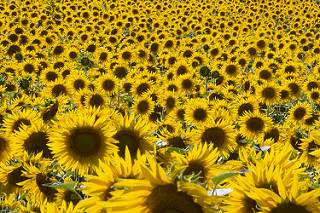

In [ ]:
# Just look at one image
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

### (2) Prepare to load images in RAM memory batch per batch 

We will use 📚 <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory">**`image_dataset_from_directory`**</a> 📚

In [ ]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size = 32
)

Found 3670 files belonging to 5 classes.


☝️ Notice how it automatically labelled our image files into the 5 classes!
- The folder structure is deduced from a default paramter:  **`labels='inferred'`** of the `image_dataset_from_directory`
- You can manually pass a list of labels instead

In [ ]:
# `ds` is a `tf.data.Dataset` object of "tuples"
ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Dataset contain no real data until they are iterated over
import sys
sys.getsizeof(ds)

48

In [ ]:
for (X_batch, y_batch)  in ds:
    print(X_batch.shape)
    print(y_batch.shape)

    break # just show the first element

(32, 256, 256, 3)
(32,)


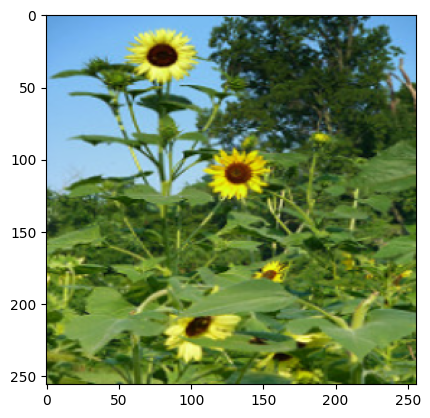

In [ ]:
# check first image
plt.imshow(X_batch[0]/255);

📚 <a href="https://www.tensorflow.org/api_docs/python/tf/keras/datasets">**tf.data.Dataset**</a> 📚 are just an abstraction that represent a sequence of elements. 



They enable us to:

- Load elements batch-per-batch in memory
- From different formats, storage places, etc...
- Apply preprocessing on the fly (ex: shuffle, resize, and many many more)

📚 [**tf/guide/data**](https://www.tensorflow.org/guide/data) 📚

### (3) Train a model directly on a `Dataset`

❓ Try to fit a very simple dense Neural Network on `ds` 

- You can directly call `model.fit(ds, epochs=1)`
- Your first layer should use `layers.Flatten` to flatten a $(256,256,3)$ picture in into a ($256 \times 256 \times 3$) vector so acceptable for Dense layers
- You can use **`loss='sparse_categorical_crossentropy'`**: "*sparse_*" avoids *"one-hot-encoding"* the target with `to_categorical(y)`

In [ ]:
X_batch.shape

TensorShape([32, 256, 256, 3])

In [ ]:
y_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 3, 2, 3, 1, 2, 2, 2, 0, 3, 4, 2, 0, 4, 3, 1, 1, 4, 4, 0, 2, 1,
       3, 3, 0, 3, 1, 4, 2, 0, 4, 3], dtype=int32)>

In [ ]:
# Let's try a dummy model, just to prove that it can fit
model = Sequential()

# flattens the picture first into a (256*256*3,) vector so it can pass into a Dense layer
model.add(layers.Flatten(input_shape=(256,256,3)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense_33 (Dense)            (None, 16)                3145744   
                                                                 
 dense_34 (Dense)            (None, 5)                 85        
                                                                 
Total params: 3,145,829
Trainable params: 3,145,829
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy', # "sparse_" allows to avoid one-hot-encoding the target
    metrics = ['accuracy']
)

model.fit(ds, epochs = 1)

115/115 [==============================] - 5s 32ms/step - loss: 381.3925 - accuracy: 0.2221


💡 The accuracy of this model is approx~ 20-25% which doesn't really beat the baseline 20% (1 divided by 5 categories...)

🤡 Why ? **A Dense Neural Network Architecture is NOT designed for classifying images!**

🚀 In the next session, we will use **`Convolutional Neural Networks (CNN)`** 🚀

### (Bonus) Proper solution to the Flower problem using CNN & Early Stopping

🧑🏻‍🏫 Come back to this section after studying **Deep Learning > 03. Convolutional Neural Networks**.

In [ ]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64), # resize on the fly
    batch_size=32
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64), # resize on the fly
    batch_size=32
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
model = tf.keras.Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1. / 255))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[EarlyStopping(patience=0)]
)

Epoch 1/5
92/92 [==============================] - 4s 33ms/step - loss: 1.3843 - accuracy: 0.3951 - val_loss: 1.1397 - val_accuracy: 0.5409
Epoch 2/5
92/92 [==============================] - 2s 25ms/step - loss: 1.0925 - accuracy: 0.5497 - val_loss: 1.0859 - val_accuracy: 0.5858


🏁 Congratulations 

💾 Don't forget to `git add/push/commit` your notebook.

📆 What's next on the menu?

* **Deep Learning** **`> 01. Fundamentals`** and **`> 02. Optimizers, Fit, Loss`** helped you master the foundations of Deep Learning, what are neurons, layers, architecture, loss functions, optimizers, learning rates, ... 
    * We have been working with inputs which are **row vectors** (each row has $p$ features)
    * All the neurons from a layer are **fully connected** to the next layer

* What if we want to classify pictures instead? Each picture has a certain amount of pixels that we could potentially consider as features... But it is more complex than that. See you in the next session **Deep Learning `> 03. Convolutional Neural Networks`**!